In [4]:
import numpy as np
from numpy.random import Generator, PCG64
import timeit
import plotly.graph_objects as go
from copy import deepcopy
#np.random.seed(1234)

In [5]:
def exponential_rng(lam=1.0):  
    """ Generates exponential random number.
    
    Keywords:
        lam (float): the rate parameter, the inverse expectation of the distribution.
    
    Returns:
        exponential random number with rate lam.
    """
    return -np.log(np.random.rand()) / lam

In [6]:
def homogeneous_poisson_process(lam, T):
    arrivals = []
    t = exponential_rng(lam)
    while t <= T:
        arrivals.append(t)
        t += exponential_rng(lam)
    return arrivals

In [7]:
def totalRevenue(choices):
    
    revenueList = [0,1000,900,850,750,700,650,600,500,350]
    revenueList = np.flip(revenueList)
    revenue = 0
    for choice in choices:
        revenue += revenueList[choice]
        
    return revenue

In [8]:
def seatsSold(choices):
    return len(choices) - np.sum(np.array(choices) == 9)

In [9]:
lam_business = lambda t: 1.2*np.sin(t*np.pi/180.0)
lam_max_business = 1.2
lam_leisure = lambda t: 0.6*t/179
lam_max_leisure = 0.6
lam_economy = lambda t: 0.8*(1 + np.sin(t*np.pi/180.0 + np.pi))
lam_max_economy = 0.8

def non_homogeneous_poisson_process(lam_t, lam_max, T):
    arrivals = []
    t = exponential_rng(lam_max)
    while t <= T:
        if np.random.rand() < lam_t(t)/lam_max:
            arrivals.append(t)
        t += exponential_rng(lam_max)
    return arrivals

In [10]:
class Passenger:
    """ Generic event.
    
    Attributes:
        time (float): Event time.
        preferences (array): fare product preference weights.
    """
    
    def __init__(self, time):
        self.time = time
        self.preferences = np.zeros(10)
        
    def makeChoice(self,availabilities):
        
        probabilities = self.preferences*(availabilities > 0)
        probabilities = probabilities/np.sum(probabilities)
        
        cumsum = np.cumsum(probabilities)
        
        r = np.random.rand()
        
        choice = np.min(np.where(r < cumsum ))
        
        return choice
    
    def makeIdealChoice(self):
        
        probabilities = self.preferences
        probabilities = probabilities/np.sum(probabilities)
        
        cumsum = np.cumsum(probabilities)
        
        r = np.random.rand()
        
        choice = np.min(np.where(r < cumsum ))
        
        return choice
        
        
        
class Business(Passenger):

    def __init__(self, time):
        super().__init__(time)
        self.preferences = np.array([11, 15, 18, 20, 19, 15, 12, 11, 13, 7])
        
    def makeChoice(self,availabilities):
        return Passenger.makeChoice(self,availabilities)
    
    def makeIdealChoice(self):
        return Passenger.makeIdealChoice(self)
        
class Leisure(Passenger):

    def __init__(self, time):
        super().__init__(time)
        self.preferences = np.array([8, 9, 11, 12, 14, 15, 16, 18, 20, 7])
        
    def makeChoice(self,availabilities):
        return Passenger.makeChoice(self,availabilities)
    
    def makeIdealChoice(self):
        return Passenger.makeIdealChoice(self)
        
class Economy(Passenger):

    def __init__(self, time):
        super().__init__(time)
        self.preferences = np.array([1, 5, 8, 10, 11, 12, 13, 15, 20, 7])
        
    def makeChoice(self,availabilities):
        return Passenger.makeChoice(self,availabilities)
    
    def makeIdealChoice(self):
        return Passenger.makeIdealChoice(self)

In [11]:
class Scenario:
    """ Road scenario
    
    Attributes:
        planning_horizon (int): days.
        t (int): early sales discount
        lam_business (float):
        lam_leisure (float):
        lam_economy (float):
    """
    
    def __init__(self, 
                 planning_horizon=180,
                 t=21,
                 lam_business=1.2,
                 lam_leisure=0.6,
                 lam_economy=0.8,
                 flag=0, # 1 if we want to offer 1 product at a time 
                 availabilities=20*np.ones([10]),
                 cutoffs = np.zeros([10])
                ):
        
        self.planning_horizon = planning_horizon
        self.t = t
        
        self.lam_business = lam_business
        self.lam_leisure = lam_leisure
        self.lam_economy = lam_economy
        
        self.flag = flag
        
        self.availabilities = availabilities
        self.availabilities[-1] = np.Inf
        
        self.fare_offered = -1
        
        self.cutoffs = cutoffs
        
    def update_availabilities(self,choice,t):
        
        self.availabilities[choice] -= 1
        
        if self.flag:
            if self.availabilities[self.fare_offered] == 0 and self.fare_offered !=0:
                self.fare_offered -= 1
                availabilities[self.fare_offered] = 20
                
        for i, cutoff in enumerate(self.cutoffs):
        
            if t < cutoff:
                self.availabilities[i] = 0

                if self.fare_offered == i:
                    self.fare_offered -= 1

                    if self.flag:
                        self.availabilities[self.fare_offered] = 20
        
        

In [12]:
def simulate(scenario):
    """ Implements the simulation procedure.
    
    Keywords:
        scenario (Scenario): Road scenario.
    
    Returns:
        times (list): Event times. 
        queues (list): Queue length over time. 
    """
    
    #Initialise the simulation
    t = 179
    events = []
            
    
    revenues = 0
    
    #Trigger the first events
    
    # Generate customer arrivals
    business_arrival_process = non_homogeneous_poisson_process(lam_business, lam_max_business, t)
    for i in business_arrival_process:
        events.append(Business(i))
    
    leisure_arrival_process = non_homogeneous_poisson_process(lam_leisure, lam_max_leisure, t)
    for i in leisure_arrival_process:
        events.append(Leisure(i))
    
    economy_arrival_process = non_homogeneous_poisson_process(lam_economy, lam_max_economy, t)
    for i in economy_arrival_process:
        events.append(Economy(i))
        
    events.sort(key=lambda event: event.time)
    
    '''
    termination = Termination(scenario.demand_duration)
    events = [generation, termination]
    '''
    choices = []
    idealChoices = []
    customerSatisfaction = []
    #Main loop
    while len(events):
        
        t = events[0].time
        
        e = events[0]
        
        choice = e.makeChoice(scenario.availabilities)
        choices.append(choice)
        
        idealChoice = e.makeIdealChoice()
        idealChoices.append(idealChoice)
        if scenario.availabilities[choice] == 0:
            customerSatisfaction.append((e.preferences[choice] - e.preferences[idealChoice])*((e.preferences[idealChoice] - e.preferences[choice])>0))
        else:
            customerSatisfaction.append(0)
        
        scenario.update_availabilities(choice,t)
        
            
        events.pop(0)
    
        
    return choices, idealChoices, customerSatisfaction

In [13]:
choices,idealChoices = simulate(Scenario(1))

ValueError: too many values to unpack (expected 2)

In [14]:
def evaluate(startAvail,startCutoffs, numIter = 10):
    
    revList = []
    
    for i in range(numIter):
    
        scenario = Scenario(availabilities = deepcopy(startAvail),cutoffs = deepcopy(startCutoffs))
        choices, idealChoices, satistfaction = simulate(scenario)
        revenue = totalRevenue(deepcopy(choices))
        
        revList.append(revenue)
        
        
    revenue = np.mean(revList)
    std = np.std(revList)/revenue
        

    return [[revenue, std]]

In [15]:
def evaluateSat(startAvail,startCutoffs, numIter = 10):
    
    revList = []
    satList = []
    
    for i in range(numIter):
    
        scenario = Scenario(availabilities = startAvail,cutoffs = startCutoffs)
        choices, idealChoices, customerSatisfaction = simulate(scenario)
        revenue = totalRevenue(choices)
        
        revList.append(revenue)
        satList.append(np.mean(customerSatisfaction))
        
    revenue = np.mean(revList)
    std = np.std(revList)
    sat = np.mean(satList)
        

    return [[revenue, sat]]

In [16]:
def generateAvailabilities(rg,availabilities,mode='ls'):
         
    
    if mode == 'ls' or mode == 'sa':
        
        availabilities = generateAvailabilities_LS(rg,availabilities)
        
    elif mode == 'fe':
        availabilities = generateAvailabilities_FE(rg,availabilities)
        
    return availabilities
        
        

In [17]:
def generateAvailabilities_LS(rg,availabilities):
    
    numBuckets = len(availabilities)-1
    
    buckets = np.arange(numBuckets)
    
    canChange = False
    
    while not canChange:
        
        numToChange = rg.integers(1,high=numBuckets/2,endpoint=False)

        whichToChange = rg.choice(buckets,size=numToChange,replace=False)

        notYetChanged = np.setdiff1d(buckets,whichToChange)

        canBeChanged = notYetChanged[np.where(availabilities[notYetChanged]>0)]


        if len(canBeChanged) > numToChange:
            canChange = True

        othersToChange = rg.choice(canBeChanged,size=numToChange,replace=False)
        
        
        availabilities[whichToChange] += 1
        availabilities[othersToChange] -= 1
        
    return availabilities
    

In [18]:
def generateAvailabilities_FE(rg,availabilities):
    
    valid = False
    
    numBuckets = len(availabilities)-1
    
    numSeats = 180
    
    while not valid:
        newAvails = rg.integers(0,numSeats,size=numBuckets)
        
        if np.sum(newAvails) <= numSeats:
            valid = True
            
    availabilities[:-1] = newAvails
    
    print("done")
        
    return availabilities
    

In [19]:
def generateCutoffs(rg,cutoffs,mode='ls'):
    
    if mode == 'ls' or mode == 'sa':
        cutoffs = generateCutoffs_LS(rg,cutoffs)
        
    elif mode == 'fe':
        cutoffs = generateCutoffs_FE(rg,cutoffs)
    
    return cutoffs
                

In [20]:
def generateCutoffs_LS(rg,cutoffs):
    
    numBuckets = len(cutoffs)-1
    
    buckets = np.arange(numBuckets)
    

    numToChange = rg.integers(1,high=numBuckets,endpoint=True)
    whichToChange = rg.choice(buckets,size=numToChange,replace=False)

    for idx in whichToChange:
        if cutoffs[idx] == 0:
            cutoffs[idx]+=1
        elif rg.random() > .50:
            cutoffs[idx] += 1
        else:
            cutoffs[idx] -= 1
                
    return cutoffs

In [21]:
def generateCutoffs_FE(rg,cutoffs):
    
    numBuckets = len(cutoffs)-1
    
    maxNumDays = 180
    
    newCutoffs = rg.integers(0,maxNumDays,size=numBuckets)
    
    cutoffs[:-1] = newCutoffs
                
    return cutoffs

In [22]:
def generateSolutions(rg,solution,mode='ls',version='combined'):
    
        
    availabilities = solution[0]
    cutoffs = solution[1]
    
    cf = cutoffs
    av = availabilities
    
    if version == "av" or version=="combined":
        
    
        av = generateAvailabilities(rg,availabilities,mode)
        
    if version == 'cf' or version == 'combined':
    
        cf = generateCutoffs(rg,cutoffs,mode)
    
    return [av, cf]

In [23]:
def dominates(test,testScore,pList,listScores):
    
        
    dominatesList = []
    
    meanRev = testScore[0][0]
    stdRev = testScore[0][1]
    
    for idx, val in enumerate(listScores):
        if meanRev >= val[0] and stdRev <= val[1]:
            if meanRev > val[0] or stdRev < val[1]:
                dominatesList.append(idx)
                    
    return dominatesList
    

In [24]:
def dominatesSat(test,testScore,pList,listScores):
    
        
    dominatesList = []
    
    meanRev = testScore[0][0]
    sat = testScore[0][1]
    
    for idx, val in enumerate(listScores):
        if meanRev >= val[0] and sat >= val[1]:
            if meanRev > val[0] or sat > val[1]:
                dominatesList.append(idx)
                    
    return dominatesList

In [25]:
def temperature_linear(init, i, iterations):
    # linear temperature decrease
    return init * (1-i/iterations)

def temperature_nonlinear(init, i, iterations):
    p_0 = 0.999
    p_f = 0.001
    return -init/np.log(p_0+(p_f-p_0)/iterations*i)

In [26]:
def searchPareto(rg, candidates,candidateScores,mode='ls',version="combined"):
        
    if  len(candidates)==1:
        choiceIdx = 0
    else:
        choiceIdx = rg.choice(np.arange(0,len(candidates)-1))
        
        
    choice = candidates[choiceIdx][:]
    scores = candidateScores[choiceIdx]
    
                          
    newCand = generateSolutions(rg,deepcopy(choice),version=version,mode=mode) 
    newCandScore = evaluate(deepcopy(newCand[0]),deepcopy(newCand[1]))
         
                          
    D = []
    S = []
                              
        
    D = dominates(deepcopy(newCand),deepcopy(newCandScore),deepcopy(candidates),deepcopy(candidateScores))
    
    solutionList = deepcopy(candidates)
    valuesList = deepcopy(candidateScores)
    
    
    for i in range(len(candidates)):
                
        
        if len(dominates(candidates[i],[candidateScores[i]],newCand,newCandScore))>0:
            S.append(i)
            
            
    if len(S)==0:
        
        for i in range(len(D)-1,-1,-1):
            solutionList.pop(i)
            valuesList.pop(i)
            
        solutionList += [newCand]
        valuesList += newCandScore

        
            
    return solutionList, valuesList
                        

In [63]:
def simulatedAnnealingChoice(rg, candidates, newCand, startScore, newCandScore, T):
    
    r = rg.random()

    P = np.min( [1,np.exp(np.max( (np.array(startScore) - np.array(newCandScore))/T ))] )

    if r < P:
        newChoice = newCand  

    else:

        if  len(candidates)==1:
            choiceIdx = 0
        else:
            choiceIdx = rg.choice(np.arange(0,len(candidates)-1))

        newChoice = candidates[choiceIdx]
        
    return newChoice

In [64]:
def searchPareto_SA(rg, candidates,candidateScores,startVal,T,version="combined"):
    
        
    startScore = evaluate(deepcopy(startVal[0]),deepcopy(startVal[1]))
                          
    newCand = generateSolutions(rg,startVal,version=version) 
    newCandScore = evaluate(deepcopy(newCand[0]),deepcopy(newCand[1]))
         
                          
    D = []
    S = []
                              
        
    D = dominates(deepcopy(newCand),deepcopy(newCandScore),deepcopy(candidates),deepcopy(candidateScores))
    
    solutionList = deepcopy(candidates)
    valuesList = deepcopy(candidateScores)
    
    
    for i in range(len(candidates)):
                
        
        if len(dominates(candidates[i],[candidateScores[i]],deepcopy(newCand),deepcopy(newCandScore)))>0:
            S.append(i)
            
            
    if len(S)==0:
        
        if len(dominates(deepcopy(newCand),deepcopy(newCandScore),deepcopy(startVal),deepcopy(startScore)))>0:
                
            for i in range(len(D)-1,-1,-1):
                solutionList.pop(i)
                valuesList.pop(i)

            solutionList += [newCand]
            valuesList += newCandScore
            
            newChoice = newCand
            
        else:
            newChoice = simulatedAnnealingChoice(rg, candidates, newCand, startScore, newCandScore, T)
            
    else:
        newChoice = simulatedAnnealingChoice(rg, candidates, newCand, startScore, newCandScore, T)
                 
            
    return solutionList, valuesList, newChoice

In [65]:
def searchParetoSat(rg, candidates,candidateScores,version="combined"):
        
    if  len(candidates)==1:
        choiceIdx = 0
    else:
        choiceIdx = rg.choice(np.arange(0,len(candidates)-1))
        
        
    choice = candidates[choiceIdx][:]
    scores = candidateScores[choiceIdx]
    
                          
    newCand = generateSolutions(rg,deepcopy(choice),version=version)
    

    
    newCandScore = evaluateSat(deepcopy(newCand[0]),deepcopy(newCand[1]))
         
                          
    D = []
    S = []
                              
        
    D = dominatesSat(deepcopy(newCand),deepcopy(newCandScore),deepcopy(candidates),deepcopy(candidateScores))
    
    solutionList = deepcopy(candidates)
    valuesList = deepcopy(candidateScores)
    
    
    for i in range(len(candidates)):
                
        if len(dominates(candidates[i],[candidateScores[i]],newCand,newCandScore))>0:
            S.append(i)
            
            
    if len(S)==0:
        
        for i in range(len(D)-1,-1,-1):
            solutionList.pop(i)
            valuesList.pop(i)
            
        solutionList += [newCand]
        valuesList += newCandScore
            
            
    return solutionList, valuesList
                        

In [66]:
def LocalSearchPareto(rg, startSoln, iterations,version='combined',mode='ls'):
    tracker = [] # a list of tuple to track the max revenue
    
    av = deepcopy(startSoln[0])
    cf = deepcopy(startSoln[1])

    best_val = evaluate(av,cf) # calculate the inital objective function
    
    #best_val = [[revenue, std]] # save the current solution as the "best solution"
    best_solution = [startSoln]                        # save the current solution as the "best solution"
    
    
    print("running algorithm...")
    start_time = timeit.default_timer() # implement a timer to track running time
    
    for i in range(1, iterations):   
        
        best_solution, best_val = searchPareto(rg,best_solution,best_val,version=version,mode=mode)
        
                 
                
    print("algorithm end.")
    end_time = timeit.default_timer()
    print("time taken :{0:.5f}s".format(end_time - start_time))

    
    return best_solution, best_val

In [67]:
def LocalSearchParetoSat(rg, startSoln, iterations,version='combined'):
    tracker = [] # a list of tuple to track the max revenue
    
    av = startSoln[0].copy()
    cf = startSoln[1].copy()

    best_val = evaluateSat(av,cf) # calculate the inital objective function
    
    #best_val = [[revenue, std]] # save the current solution as the "best solution"
    best_solution = [startSoln]                        # save the current solution as the "best solution"
    
    
    print("running algorithm...")
    start_time = timeit.default_timer() # implement a timer to track running time
    
    for i in range(1, iterations):   
        
        best_solution, best_val = searchPareto(rg,best_solution,best_val,version=version)
        
                 
                
    print("algorithm end.")
    end_time = timeit.default_timer()
    print("time taken :{0:.5f}s".format(end_time - start_time))

    
    return best_solution, best_val

In [68]:
def LocalSearchPareto_SA(rg, startSoln, iterations,t_init=1,version='combined'):
    tracker = [] # a list of tuple to track the max revenue
    
    av = startSoln[0].copy()
    cf = startSoln[1].copy()

    best_val = evaluateSat(av,cf) # calculate the inital objective function
    
    #best_val = [[revenue, std]] # save the current solution as the "best solution"
    best_solution = [startSoln]                        # save the current solution as the "best solution"
    
    
    print("running algorithm...")
    start_time = timeit.default_timer() # implement a timer to track running time
        
    
    for i in range(1, iterations):  
        
        T = temperature_nonlinear(t_init, i, iterations)
        
        best_solution, best_val, startSoln = searchPareto_SA(rg,best_solution,best_val,startSoln,T,version=version)
        
                 
                
    print("algorithm end.")
    end_time = timeit.default_timer()
    print("time taken :{0:.5f}s".format(end_time - start_time))

    
    return best_solution, best_val

In [69]:
rg = Generator(PCG64(4209)) # set your own unique seed number

startAv = 20*np.ones([10])
startAv[-1] = np.Inf

startCf = np.zeros([10])
startCf[3] = 21
startCf[7] = 21

startSoln = [startAv,startCf]

#evaluate(startAv,startCf)

best_soln, best_revenue = LocalSearchPareto_SA(rg,startSoln,1000,version='combined')
#best_soln, best_revenue = LocalSearch(rg,best_soln,1000,version='cf')



running algorithm...


<ipython-input-63-0c6f747d4bd4>:5: RuntimeWarning: overflow encountered in exp
  P = np.min( [1,np.exp(np.max( (np.array(startScore) - np.array(newCandScore))/T ))] )


KeyboardInterrupt: 

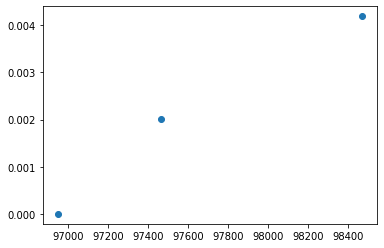

In [464]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(np.array(best_revenue)[:,0],np.array(best_revenue)[:,1])
plt.show()

In [462]:
np.array(best_revenue)

array([[9.75300000e+04, 2.66584641e-03]])

In [364]:
best_soln

[[array([21., 19., 21., 19., 15., 18., 21., 23., 23., inf]),
  array([ 0.,  0.,  0., 22.,  0.,  0.,  0., 21.,  0.,  0.])]]

In [285]:
evaluate(best_soln[0][0],best_soln[0][1])

[[95155.0, 315.0]]